<a href="https://colab.research.google.com/github/srija-guda/Anomalies-in-WBAN-MIMIC4/blob/main/WBAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, Dropout,Bidirectional
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

In [2]:
df = pd.read_csv('final_data.csv')

In [3]:
df.head()

,charttime,ABPd,ABPm,ABPs,HR,RR,SpO2,Temperature C,point_anomaly,contextual_anomaly,final_label
0,2160-05-18 14:06:00,75.0,94.0,134.0,80.0,14.0,100.0,37.2,0,0,0
1,2160-05-18 14:07:00,75.0,94.0,134.0,80.0,14.0,100.0,37.2,0,0,0
2,2160-05-18 14:18:00,75.0,94.0,134.0,80.0,14.0,100.0,37.2,0,0,0
3,2160-05-18 15:00:00,55.0,66.0,90.0,88.0,14.0,100.0,37.0,0,0,0
4,2160-05-18 16:00:00,70.0,88.0,122.0,92.0,14.0,100.0,36.9,0,0,0


In [4]:
df = df.drop(columns=['charttime'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143694 entries, 0 to 143693
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ABPd                143694 non-null  float64
 1   ABPm                143694 non-null  float64
 2   ABPs                143694 non-null  float64
 3   HR                  143694 non-null  float64
 4   RR                  143694 non-null  float64
 5   SpO2                143694 non-null  float64
 6   Temperature C       143694 non-null  float64
 7   point_anomaly       143694 non-null  int64  
 8   contextual_anomaly  143694 non-null  int64  
 9   final_label         143694 non-null  int64  
dtypes: float64(7), int64(3)
memory usage: 11.0 MB


In [6]:
df.isna().sum()

,0
ABPd,0
ABPm,0
ABPs,0
HR,0
RR,0
SpO2,0
Temperature C,0
point_anomaly,0
contextual_anomaly,0
final_label,0


In [7]:
scaler = MinMaxScaler()
numerical_features = df.select_dtypes(include=['number']).columns
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [8]:
df.describe()

,ABPd,ABPm,ABPs,HR,RR,SpO2,Temperature C,point_anomaly,contextual_anomaly,final_label
count,143694.000000,143694.000000,143694.000000,143694.000000,143694.000000,143694.000000,143694.000000,143694.000000,143694.000000,143694.000000
mean,0.331169,0.151798,0.431801,0.193761,0.448404,0.153436,0.578309,0.047831,0.041129,0.044480
std,0.153916,0.072507,0.155583,0.083006,0.173055,0.056475,0.115624,0.213409,0.198589,0.202055
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.222222,0.109566,0.333333,0.137662,0.314286,0.137726,0.533333,0.000000,0.000000,0.000000
50%,0.311111,0.139791,0.413333,0.183549,0.428571,0.148321,0.583333,0.000000,0.000000,0.000000
75%,0.422222,0.181351,0.526667,0.240909,0.542857,0.158915,0.633333,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
train_size = int(len(df) * 0.67)
test_size = len(df) - train_size

In [10]:
# def create_dataset(dataset, look_back=1):
#     dataX, dataY = [], []
#     for i in range(len(dataset) - look_back - 1):
#         a = dataset.iloc[i:(i + look_back), :].values
#         dataX.append(a)
#         dataY.append(dataset.iloc[i + look_back, 0])
#     return np.array(dataX), np.array(dataY)

In [11]:
columns = ['ABPd', 'ABPm',	'ABPs',	'HR' ,'RR',	'SpO2',	'Temperature C']

In [12]:
def LSTM_encoder_custom(seq_length, num_features):
    inputs = Input(shape=(seq_length, num_features))

    # Encoder
    encoded = LSTM(32, activation='relu', return_sequences=True)(inputs)
    encoded = LSTM(16, activation='relu', return_sequences=True)(encoded)
    encoded=Dropout(0.2)(encoded)
    encoded = LSTM(8, activation='relu', return_sequences=False)(encoded)
    # Decoder
    decoded = RepeatVector(seq_length)(encoded)
    decoded = LSTM(8, activation='relu', return_sequences=True)(decoded)
    decoded = LSTM(16, activation='relu', return_sequences=True)(decoded)
    decoded=Dropout(0.2)(decoded)
    decoded = LSTM(32, activation='relu', return_sequences=True)(decoded)
    decoded = TimeDistributed(Dense(num_features, activation='linear', kernel_regularizer=l2(0.001)))(decoded)
    model = Model(inputs, decoded)
    model.compile(optimizer=Adam(learning_rate=0.008), loss='mse')

    return model

In [13]:
seq_len=1
EPOCH = 20

In [14]:
def create_dataset(X, time_steps=1):
    Xs= []
    for i in range(len(X)-time_steps+1):
        v=X[i:(i+time_steps)]
        Xs.append(v)
    return np.array(Xs)

In [15]:
data_w=df
data_train = data_w.sample(frac=0.7, random_state=1)
data_test = data_w.drop(data_train.index)
data_train_n=data_train[data_train['point_anomaly']==0]

In [16]:
columns = ['ABPd', 'ABPm',	'ABPs',	'HR' ,'RR',	'SpO2',	'Temperature C']
mse_train_temp = []
mse_test_temp = []
mse_train_hr=[]
mse_test_hr=[]
mse_train_rr=[]
mse_test_rr=[]
mse_train_spo2=[]
mse_test_spo2=[]
mse_train_abpd=[]
mse_test_abpd=[]
mse_train_abpm=[]
mse_test_abpm=[]
mse_train_abps=[]
mse_test_abps=[]

In [17]:
feat = 'ABPd'
print('Feature:',feat)
model=LSTM_encoder_custom(seq_len,1)
scaler=StandardScaler()
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
X_train=data_train_n[feat]
X_train=scaler.fit_transform(np.array(X_train).reshape(-1,1))
X_train=create_dataset(X_train,seq_len)
# print(X_train.shape)
model.fit(X_train,X_train,epochs=EPOCH,batch_size=32,validation_split=0.2,callbacks=[callback])
X_train_pred=model.predict(X_train)
mse_train_abpd=np.mean(np.power(X_train-X_train_pred,2),axis=1)
X_test=data_train[feat].values
Y_test=data_train['point_anomaly'].values
X_test=scaler.fit_transform(np.array(X_test).reshape(-1,1))
X_test=create_dataset(X_test,seq_len)
X_test_pred=model.predict(X_test)
mse_test_abpd=np.mean(np.power(X_test-X_test_pred,2),axis=1)

Feature: ABPd
Epoch 1/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - loss: 0.9871 - val_loss: 1.0066
Epoch 2/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 1.0102 - val_loss: 1.0041
Epoch 3/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 1.0009 - val_loss: 1.0045
Epoch 4/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 1.0018 - val_loss: 1.0044
Epoch 5/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 1.0155 - val_loss: 1.0041
Epoch 6/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.9926 - val_loss: 1.0053
Epoch 7/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 1.0076 - val_loss: 1.0043
2992/2992 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step
3144/3144 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


In [18]:
X_train.shape

(95740, 1, 1)

In [19]:
X_test.shape

(100586, 1, 1)

In [20]:
feat = 'ABPm'
print('Feature:',feat)
model=LSTM_encoder_custom(seq_len,1)
scaler=StandardScaler()
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
X_train=data_train_n[feat]
X_train=scaler.fit_transform(np.array(X_train).reshape(-1,1))
X_train=create_dataset(X_train,seq_len)
# print(X_train.shape)
model.fit(X_train,X_train,epochs=EPOCH,batch_size=32,validation_split=0.2,callbacks=[callback])
X_train_pred=model.predict(X_train)
mse_train_abpm=np.mean(np.power(X_train-X_train_pred,2),axis=1)
X_test=data_train[feat].values
Y_test=data_train['point_anomaly'].values
X_test=scaler.fit_transform(np.array(X_test).reshape(-1,1))
X_test=create_dataset(X_test,seq_len)
X_test_pred=model.predict(X_test)
mse_test_abpm=np.mean(np.power(X_test-X_test_pred,2),axis=1)

Feature: ABPm
Epoch 1/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - loss: 0.1944 - val_loss: 0.0464
Epoch 2/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - loss: 0.0154 - val_loss: 0.1010
Epoch 3/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - loss: 0.0110 - val_loss: 0.1053
Epoch 4/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 0.0079 - val_loss: 0.1040
Epoch 5/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.0102 - val_loss: 0.1178
Epoch 6/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 0.0082 - val_loss: 0.1389
2992/2992 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
3144/3144 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


In [21]:
feat = 'ABPs'
print('Feature:',feat)
model=LSTM_encoder_custom(seq_len,1)
scaler=StandardScaler()
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
X_train=data_train_n[feat]
X_train=scaler.fit_transform(np.array(X_train).reshape(-1,1))
X_train=create_dataset(X_train,seq_len)
# print(X_train.shape)
model.fit(X_train,X_train,epochs=EPOCH,batch_size=32,validation_split=0.2,callbacks=[callback])
X_train_pred=model.predict(X_train)
mse_train_abps=np.mean(np.power(X_train-X_train_pred,2),axis=1)
X_test=data_train[feat].values
Y_test=data_train['point_anomaly'].values
X_test=scaler.fit_transform(np.array(X_test).reshape(-1,1))
X_test=create_dataset(X_test,seq_len)
X_test_pred=model.predict(X_test)
mse_test_abps=np.mean(np.power(X_test-X_test_pred,2),axis=1)

Feature: ABPs
Epoch 1/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - loss: 0.1862 - val_loss: 0.0602
Epoch 2/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - loss: 0.0078 - val_loss: 0.0573
Epoch 3/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - loss: 0.0056 - val_loss: 0.0403
Epoch 4/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - loss: 0.0048 - val_loss: 0.0570
Epoch 5/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 43s 10ms/step - loss: 0.0036 - val_loss: 0.0598
Epoch 6/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - loss: 0.0039 - val_loss: 0.0523
Epoch 7/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 0.0035 - val_loss: 0.0426
Epoch 8/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 0.0038 - val_loss: 0.0433
2992/2992 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step
3144/3144 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


In [22]:
feat = 'HR'
print('Feature:',feat)
model=LSTM_encoder_custom(seq_len,1)
scaler=StandardScaler()
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
X_train=data_train_n[feat]
X_train=scaler.fit_transform(np.array(X_train).reshape(-1,1))
X_train=create_dataset(X_train,seq_len)
# print(X_train.shape)
model.fit(X_train,X_train,epochs=EPOCH,batch_size=32,validation_split=0.2,callbacks=[callback])
X_train_pred=model.predict(X_train)
mse_train_hr=np.mean(np.power(X_train-X_train_pred,2),axis=1)
X_test=data_train[feat].values
Y_test=data_train['point_anomaly'].values
X_test=scaler.fit_transform(np.array(X_test).reshape(-1,1))
X_test=create_dataset(X_test,seq_len)
X_test_pred=model.predict(X_test)
mse_test_hr=np.mean(np.power(X_test-X_test_pred,2),axis=1)

Feature: HR
Epoch 1/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - loss: 0.2700 - val_loss: 0.0094
Epoch 2/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - loss: 0.0145 - val_loss: 0.0250
Epoch 3/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - loss: 0.0085 - val_loss: 0.0351
Epoch 4/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - loss: 0.0078 - val_loss: 0.0451
Epoch 5/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - loss: 0.0054 - val_loss: 0.0489
Epoch 6/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - loss: 0.0051 - val_loss: 0.0550
2992/2992 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step
3144/3144 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


In [23]:
feat = 'RR'
print('Feature:',feat)
model=LSTM_encoder_custom(seq_len,1)
scaler=StandardScaler()
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
X_train=data_train_n[feat]
X_train=scaler.fit_transform(np.array(X_train).reshape(-1,1))
X_train=create_dataset(X_train,seq_len)
# print(X_train.shape)
model.fit(X_train,X_train,epochs=EPOCH,batch_size=32,validation_split=0.2,callbacks=[callback])
X_train_pred=model.predict(X_train)
mse_train_rr=np.mean(np.power(X_train-X_train_pred,2),axis=1)
X_test=data_train[feat].values
Y_test=data_train['point_anomaly'].values
X_test=scaler.fit_transform(np.array(X_test).reshape(-1,1))
X_test=create_dataset(X_test,seq_len)
X_test_pred=model.predict(X_test)
mse_test_rr=np.mean(np.power(X_test-X_test_pred,2),axis=1)

Feature: RR
Epoch 1/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - loss: 0.1555 - val_loss: 0.0667
Epoch 2/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step - loss: 0.0095 - val_loss: 0.1189
Epoch 3/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - loss: 0.0074 - val_loss: 0.1113
Epoch 4/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step - loss: 0.0052 - val_loss: 0.1566
Epoch 5/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - loss: 0.0055 - val_loss: 0.1452
Epoch 6/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - loss: 0.0038 - val_loss: 0.1648
2992/2992 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
3144/3144 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


In [24]:
feat = 'SpO2'
print('Feature:',feat)
model=LSTM_encoder_custom(seq_len,1)
scaler=StandardScaler()
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
X_train=data_train_n[feat]
X_train=scaler.fit_transform(np.array(X_train).reshape(-1,1))
X_train=create_dataset(X_train,seq_len)
# print(X_train.shape)
model.fit(X_train,X_train,epochs=EPOCH,batch_size=32,validation_split=0.2,callbacks=[callback])
X_train_pred=model.predict(X_train)
mse_train_spo2=np.mean(np.power(X_train-X_train_pred,2),axis=1)
X_test=data_train[feat].values
Y_test=data_train['point_anomaly'].values
X_test=scaler.fit_transform(np.array(X_test).reshape(-1,1))
X_test=create_dataset(X_test,seq_len)
X_test_pred=model.predict(X_test)
mse_test_spo2=np.mean(np.power(X_test-X_test_pred,2),axis=1)

Feature: SpO2
Epoch 1/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 0.2189 - val_loss: 0.1314
Epoch 2/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - loss: 0.0228 - val_loss: 0.1817
Epoch 3/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - loss: 0.0152 - val_loss: 0.2928
Epoch 4/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - loss: 0.0177 - val_loss: 0.3488
Epoch 5/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - loss: 0.0121 - val_loss: 0.4352
Epoch 6/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - loss: 0.0098 - val_loss: 0.5318
2992/2992 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step
3144/3144 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


In [25]:
feat = 'Temperature C'
print('Feature:',feat)
model=LSTM_encoder_custom(seq_len,1)
scaler=StandardScaler()
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
X_train=data_train_n[feat]
X_train=scaler.fit_transform(np.array(X_train).reshape(-1,1))
X_train=create_dataset(X_train,seq_len)
# print(X_train.shape)
model.fit(X_train,X_train,epochs=EPOCH,batch_size=32,validation_split=0.2,callbacks=[callback])
X_train_pred=model.predict(X_train)
mse_train_temp=np.mean(np.power(X_train-X_train_pred,2),axis=1)
X_test=data_train[feat].values
Y_test=data_train['point_anomaly'].values
X_test=scaler.fit_transform(np.array(X_test).reshape(-1,1))
X_test=create_dataset(X_test,seq_len)
X_test_pred=model.predict(X_test)
mse_test_temp=np.mean(np.power(X_test-X_test_pred,2),axis=1)

Feature: Temperature C
Epoch 1/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - loss: 0.1709 - val_loss: 0.0464
Epoch 2/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - loss: 0.0114 - val_loss: 0.0687
Epoch 3/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 43s 10ms/step - loss: 0.0110 - val_loss: 0.0544
Epoch 4/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - loss: 0.0087 - val_loss: 0.0680
Epoch 5/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - loss: 0.0067 - val_loss: 0.0955
Epoch 6/20
2394/2394 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - loss: 0.0066 - val_loss: 0.0684
2992/2992 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step
3144/3144 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


In [26]:
K = 7  # Number of features
rmse = np.sqrt((mse_train_rr + mse_train_spo2 + mse_train_hr + mse_train_abps + mse_train_temp+ mse_train_abpm + mse_train_abpd) / K)

In [27]:
rmse.shape

(95740, 1)

In [28]:
X_train.shape

(95740, 1, 1)

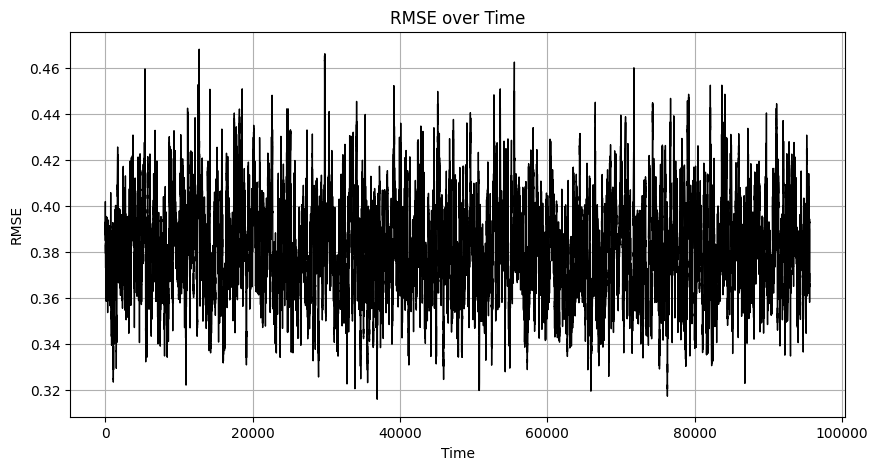

In [29]:
time = range(0, 95740)
window_size = 100
rmse = rmse.flatten()
rmse_smooth = np.convolve(rmse, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10, 5))
plt.plot(time[:len(rmse_smooth)], rmse_smooth, linestyle='-', linewidth=1, color='black')  # Thin black line
plt.xlabel('Time')
plt.ylabel('RMSE')
plt.title('RMSE over Time')
plt.grid(True)

plt.show()

In [31]:
Q1 = np.quantile(rmse, 0.25)
Q2 = np.quantile(rmse, 0.5)
Q3 = np.quantile(rmse, 0.75)
IQR = Q3 - Q1
Min = Q1- 3*IQR
Max = Q3 + 3*IQR

In [32]:
TRW = []
for i in range(len(rmse)):
    if rmse[i] > Min and rmse[i] < Q1:
        state = 0
    elif rmse[i] > Q1 and rmse[i] < Q2:
        state = 1
    elif rmse[i] > Q2 and rmse[i] < Q3:
        state = 2
    elif rmse[i] > Q3 and rmse[i] < Max:
        state = 3
    TRW.append(state)

In [33]:
q0 = TRW.count(0)/len(TRW)
q1 = TRW.count(1)/len(TRW)
q2 = TRW.count(2)/len(TRW)
q3 = TRW.count(3)/len(TRW)

Q = [q0, q1, q2, q3]

print(Q)

[0.25369751410068936, 0.2536452893252559, 0.25341550031334864, 0.23924169626070607]


In [87]:
Q

[0.25369751410068936,
 0.2536452893252559,
 0.25341550031334864,
 0.23924169626070607]

In [35]:
states = np.unique(TRW)
num_states = len(states)

N = np.zeros((num_states, num_states), dtype=int)

for i in range(len(TRW) - 1):
    current_state = TRW[i]
    next_state = TRW[i + 1]
    N[current_state, next_state] += 1

T = np.sum(N, axis=1, keepdims=True)

P = np.divide(N, T, where=(T != 0))  # Avoid division by zero

print("Transition Count Matrix (N):\n", N)
print("Outgoing Transitions (T):\n", T.flatten())
print("Transition Probability Matrix (P):\n", P)

Transition Count Matrix (N):
 [[6383 6185 6005 5716]
 [5919 6432 6189 5743]
 [6194 6078 6291 5699]
 [5793 5589 5776 5747]]
Outgoing Transitions (T):
 [24289 24283 24262 22905]
Transition Probability Matrix (P):
 [[0.26279386 0.25464202 0.24723126 0.23533287]
 [0.24375077 0.26487666 0.25486966 0.2365029 ]
 [0.25529635 0.25051521 0.25929437 0.23489407]
 [0.25291421 0.24400786 0.25217201 0.25090592]]


In [45]:
rmse_test = np.sqrt((mse_test_rr + mse_test_spo2 + mse_test_hr + mse_test_abps + mse_test_temp+ mse_test_abpm + mse_test_abpd) / K)

In [49]:
rmse

array([0.33772928, 0.52169446, 0.18434152, ..., 0.29741585, 0.33824386,
       0.27154365])

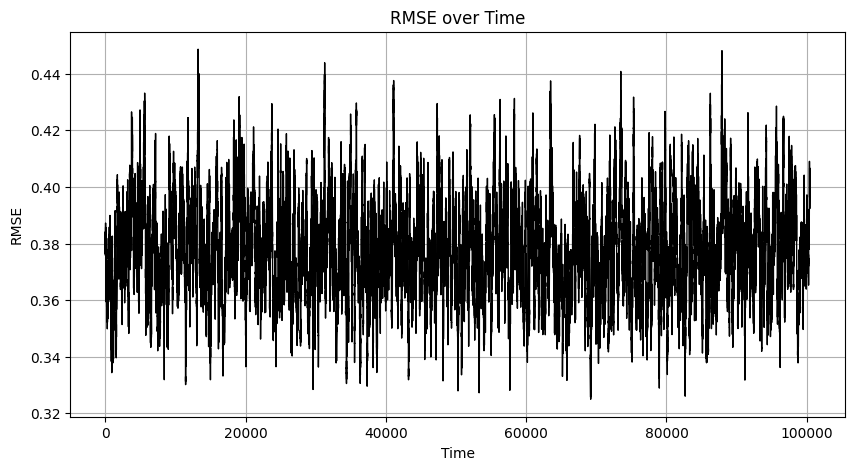

In [51]:
rmse_test = rmse_test.flatten()
time = range(0, len(rmse_test))
window_size = 150
rmse_smooth = np.convolve(rmse_test, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10, 5))
plt.plot(time[:len(rmse_smooth)], rmse_smooth, linestyle='-', linewidth=1, color='black')  # Thin black line
plt.xlabel('Time')
plt.ylabel('RMSE')
plt.title('RMSE over Time')
plt.grid(True)

plt.show()

In [52]:
Q1_test = np.quantile(rmse_test, 0.25)
Q2_test = np.quantile(rmse_test, 0.5)
Q3_test = np.quantile(rmse_test, 0.75)
IQR_test = Q3_test - Q1_test
Min_test = Q1_test- 3*IQR_test
Max_test = Q3_test + 3*IQR_test

In [55]:
TW = []
for i in range(len(rmse_test)):
    if rmse_test[i] > Min_test and rmse_test[i] < Q1_test:
        state = 0
    elif rmse_test[i] > Q1_test and rmse_test[i] < Q2_test:
        state = 1
    elif rmse_test[i] > Q2_test and rmse_test[i] < Q3_test:
        state = 2
    elif rmse_test[i] > Q3_test and rmse_test[i] < Max_test:
        state = 3
    TW.append(state)

In [56]:
window_size = 5
joint_probabilities = []
left = 0
right = window_size
n = len(TW)-1

while right<n :
    window = TW[left:right]
    joint_prob = Q[window[0]]
    for i in range(1, window_size):
        prev_state = window[i-1]
        curr_state = window[i]
        joint_prob *= P[prev_state, curr_state]
    left +=1
    right+=1
    joint_probabilities.append(joint_prob)
    print(f"Window {right + 1}: {window} -> P(SW_{right}) = {joint_prob:.6f}")

Streaming output truncated to the last 5000 lines.
Window 95587: [3, 3, 0, 3, 1] -> P(SW_95586) = 0.000872
Window 95588: [3, 0, 3, 1, 3] -> P(SW_95587) = 0.000822
Window 95589: [0, 3, 1, 3, 1] -> P(SW_95588) = 0.000841
Window 95590: [3, 1, 3, 1, 0] -> P(SW_95589) = 0.000821
Window 95591: [1, 3, 1, 0, 2] -> P(SW_95590) = 0.000882
Window 95592: [3, 1, 0, 2, 3] -> P(SW_95591) = 0.000826
Window 95593: [1, 0, 2, 3, 1] -> P(SW_95592) = 0.000876
Window 95594: [0, 2, 3, 1, 3] -> P(SW_95593) = 0.000850
Window 95595: [2, 3, 1, 3, 2] -> P(SW_95594) = 0.000866
Window 95596: [3, 1, 3, 2, 2] -> P(SW_95595) = 0.000903
Window 95597: [1, 3, 2, 2, 0] -> P(SW_95596) = 0.001001
Window 95598: [3, 2, 2, 0, 0] -> P(SW_95597) = 0.001050
Window 95599: [2, 2, 0, 0, 2] -> P(SW_95598) = 0.001090
Window 95600: [2, 0, 0, 2, 0] -> P(SW_95599) = 0.001073
Window 95601: [0, 0, 2, 0, 2] -> P(SW_95600) = 0.001040
Window 95602: [0, 2, 0, 2, 2] -> P(SW_95601) = 0.001027
Window 95603: [2, 0, 2, 2, 3] -> P(SW_95602) = 0.0009

In [57]:
min(joint_probabilities)

np.float64(0.0007967415255071919)

In [58]:
max(joint_probabilities)

np.float64(0.001248537481635323)

In [62]:
threshold = 0.000925

count_below_threshold = sum(prob < threshold for prob in joint_probabilities)

print(f"Number of elements below {threshold}: {count_below_threshold}")

Number of elements below 0.000925: 24615


In [60]:
len(joint_probabilities)

100580

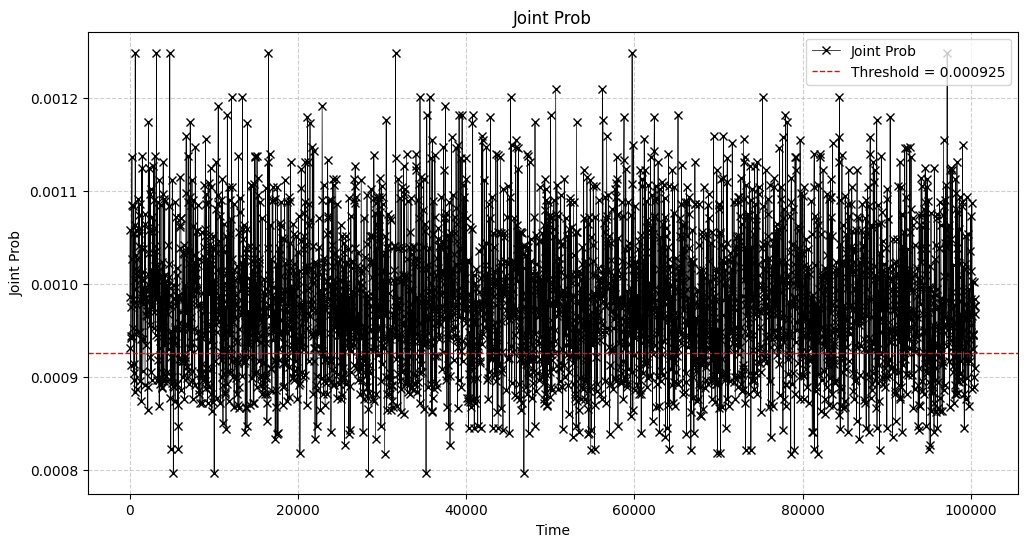

In [66]:
time = np.arange(len(joint_probabilities))

threshold = 0.000925
n = 30

plt.figure(figsize=(12, 6))

# **Plot RMSE**
plt.plot(time[::n], joint_probabilities[::n], color='black', linewidth=0.5,
         label="Joint Prob", marker='x')
plt.axhline(y=threshold, color='red', linestyle='--', linewidth=1, label=f"Threshold = {threshold}")
plt.xlabel("Time")
plt.ylabel("Joint Prob")
plt.title("Joint Prob")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.show()

In [67]:
joint_probabilities = np.array(joint_probabilities)
anomaly_indices = np.where(joint_probabilities < threshold)[0]

In [68]:
anomaly_times = time[anomaly_indices]

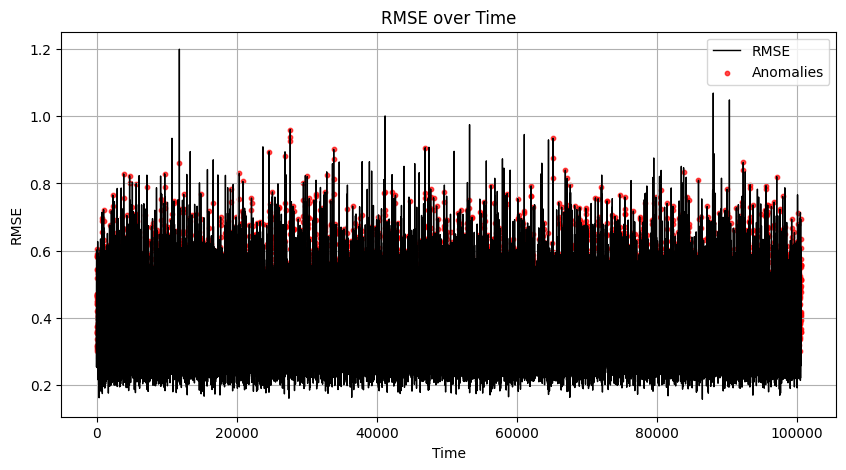

In [74]:
window_size = 5  # Adjust if needed
rmse_smooth = np.convolve(rmse_test, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10, 5))

# Plot RMSE curve
plt.plot(time[:len(rmse_smooth)], rmse_smooth, linestyle='-', linewidth=1, color='black', label="RMSE")

# Mark anomalies with red dots (instead of vertical lines)
plt.scatter(anomaly_times, rmse_smooth[anomaly_indices], color='red', s=10, label="Anomalies", alpha=0.7)

# Labels & Title
plt.xlabel('Time')
plt.ylabel('RMSE')
plt.title('RMSE over Time')
plt.grid(True)
plt.legend()

plt.show()

In [81]:
from sklearn.decomposition import PCA
pca_X = df[['ABPd', 'ABPm', 'ABPs', 'HR', 'RR', 'SpO2', 'Temperature C']]

scaler = StandardScaler()
pca_X_scaled = scaler.fit_transform(pca_X)

pca = PCA()
pca.fit(pca_X_scaled)

PCA()

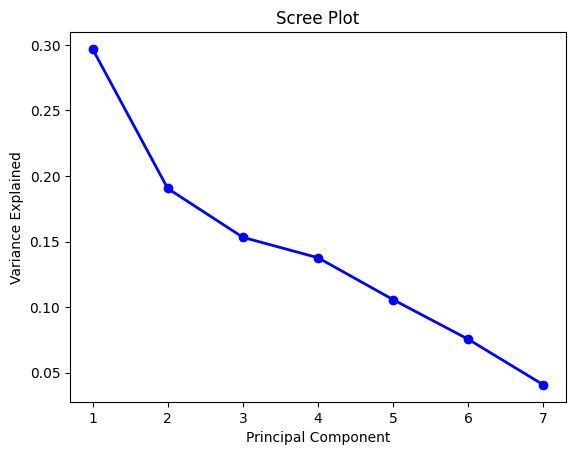

In [82]:
PC_values = np.arange(1, len(pca.explained_variance_ratio_) + 1)
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

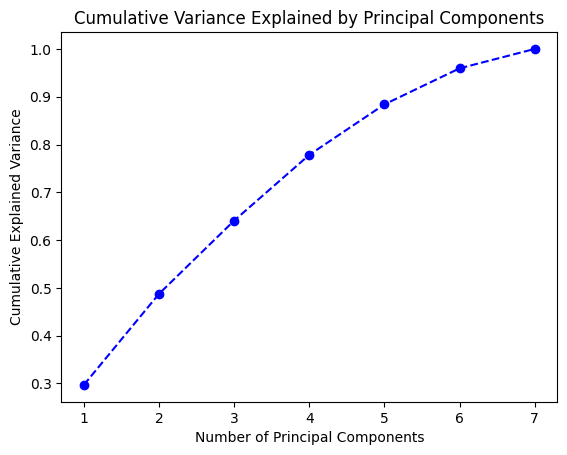

In [83]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(PC_values , cumulative_variance, marker='o', linestyle='--', color='b')
plt.title('Cumulative Variance Explained by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [85]:
n_components = np.argmax(cumulative_variance >= 0.6) + 1
components = pd.DataFrame(pca.components_[:n_components], columns=pca_X.columns)
top_features = components.abs().idxmax(axis=1)
for i, feature in enumerate(top_features):
    print(f"PC{i+1}: {feature} ")

PC1: ABPm 
PC2: HR 
PC3: SpO2 


In [76]:
# from sklearn.metrics import mean_squared_error, r2_score

# for col in columns:
#     df_selected = df[[col, 'point_anomaly', 'contextual_anomaly', 'final_label']]
#     look_back = 5
#     X, y = create_dataset(df_selected, look_back)
#     X_train, X_test = X[:train_size], X[train_size:]
#     y_train, y_test = y[:train_size], y[train_size:]
#     model = Sequential()
#     model.add(LSTM(20, input_shape=(look_back, 4)))
#     model.add(Dense(1))
#     model.compile(loss='mean_squared_error', optimizer='adam')
#     model.fit(X_train, y_train, epochs=20, batch_size=128, verbose=1)

#     # Predict on the test set
#     y_pred = model.predict(X_test)

#     # Define a tolerance level for correct predictions (e.g., 5% of the actual value)
#     tolerance = 0.05

#     # Calculate accuracy based on the tolerance
#     correct_predictions = np.sum(np.abs(y_test - y_pred.flatten()) <= tolerance * y_test) # flattening the y_pred to ensure compatibility for vector-wise comparison
#     accuracy = correct_predictions / len(y_test)

#     print(f"Test Accuracy (Tolerance {tolerance*100:.0f}%): {accuracy:.4f}")
